In [21]:
import torch
import torch.nn as nn
import torchvision
from datasets import load_dataset
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import mlflow
import mlflow.pytorch
import os
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

In [2]:
config = {
    'num_rows': 2000,
    'image_size': 64,
    'learning_rate': 0.001,
    'num_epochs': 32,
    'batch_size':32
}

label_dict = {
    0: 'Annual Crop',
    1: 'Forest',
    2: 'Herbaceous Vegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'Permanent Crop',
    7: 'Residential',
    8: 'River',
    9: 'Sea/Lake'
}


In [3]:
# Load the huggingface dataset
dataset = load_dataset('jonathan-roberts1/EuroSAT')

In [4]:
#select subset of data and shuffle 
dataset = dataset['train'].shuffle(seed=42).select(range(config['num_rows']))

In [5]:
#Split into train and test+validation
train_test_valid = dataset.train_test_split(test_size=0.2, seed=42)
train_data = train_test_valid['train']
test_valid_dataset = train_test_valid['test']

#Split the test+validation set into test and validation
test_valid_split = test_valid_dataset.train_test_split(test_size=0.5, seed=42)
test_data = test_valid_split['test']
val_data = test_valid_split['train']

# Check sizes of the splits
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 1600
Validation set size: 200
Test set size: 200


In [6]:
#create dataset class
class EuroSATDataset(Dataset):
    def __init__(self, hf_dataset, transform = None):
        self.data = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']
        label = torch.tensor(item['label'], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

data_transform = transforms.Compose([
    transforms.Resize((config['image_size'], config['image_size'])),
    transforms.ToTensor()])
    

In [7]:
train_dataset = EuroSATDataset(train_data, data_transform)
val_dataset = EuroSATDataset(val_data, data_transform)
test_dataset = EuroSATDataset(test_data, data_transform)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True)

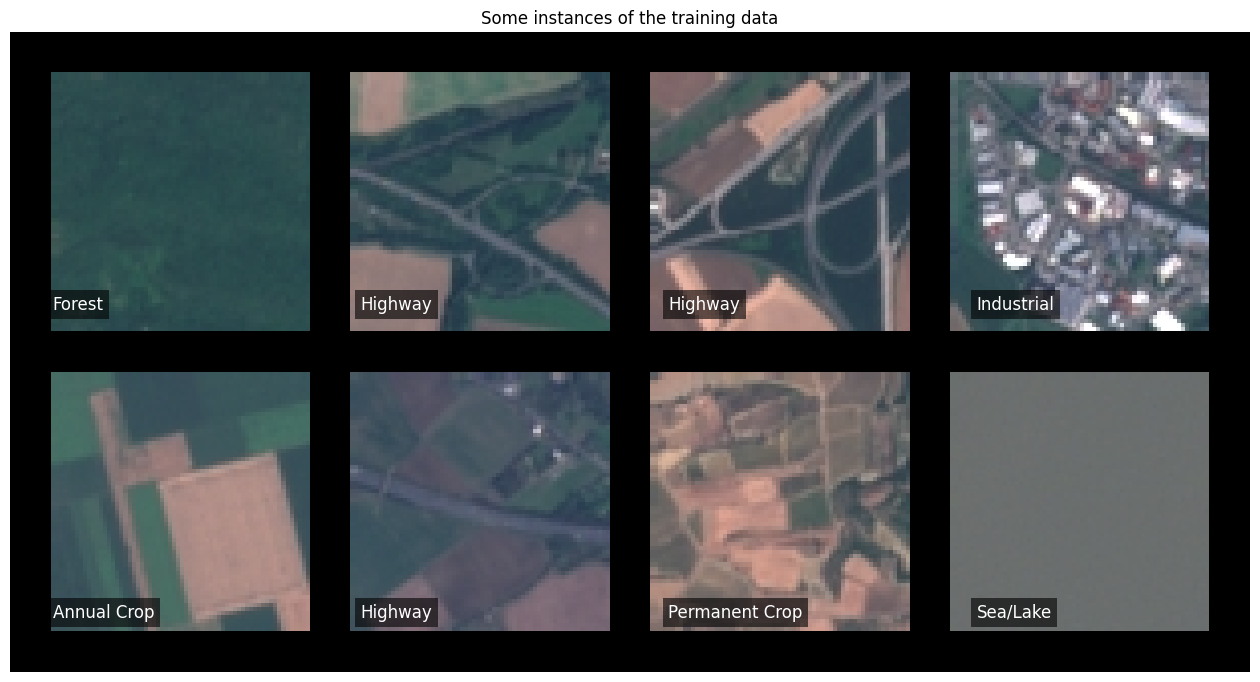

In [9]:
# Display the images
images, labels = next(iter(train_dataloader))
plt.figure(figsize=(16, 24))
grid_imgs = torchvision.utils.make_grid(images[:8], nrow=4, padding=10)
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1, 2, 0)))

# Add labels for each image
for i in range(8): 
    plt.text(
        x=10 + (i % 4) * (grid_imgs.shape[2] // 4),  
        y=grid_imgs.shape[1] - 90 + (i // 4) * (grid_imgs.shape[2] // 4),  
        s=label_dict[labels[i].item()],  
        color="white",
        fontsize=12,
        bbox=dict(facecolor='black', alpha=0.6, edgecolor='none'),
    )
plt.title('Some instances of the training data')
plt.axis("off")
plt.show()

In [10]:
#singe kernel application function
def apply_kernel(input_slice, weigths, bias):
    s = input_slice*weigths
    Z = torch.sum(s) + bias
    Z = Z.to(torch.float32)
    return Z

#slice kernel function over inputs
def slice_over_input(inputs, stride, weigths, bias):

    #get dimensions of inputs
    C_in, H_in, W_in = inputs.shape[0] , inputs.shape[1], inputs.shape[2]

    f = weigths.shape[1]

    H_out = (H_in - f)//stride + 1
    W_out = (W_in - f)//stride + 1

    Z = torch.zeros(1, H_out, W_out)

    for h in range(H_out):
        vert_start = h
        vert_end = h + f

        for w in range(W_out):
            horiz_start = w
            horiz_end = w + f

            current_slice = inputs[: , vert_start:vert_end, horiz_start:horiz_end]
            Z[0, h, w] = apply_kernel(current_slice, weigths, bias)
    
    return Z

    

Input shape: torch.Size([3, 64, 64])
Kernel shape: torch.Size([3, 3, 3])
Output shape: torch.Size([1, 62, 62])


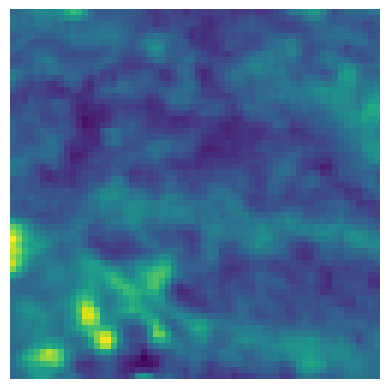

In [11]:
#test the function with a random noise filter
weights = torch.tensor(np.random.rand(3,3,3), dtype=torch.float32)
#image, label = next(iter(train_dataloader))

inputs = images[0]

output = slice_over_input(inputs, 1, weights, 0)

print("Input shape:", inputs.shape)
print("Kernel shape:", weights.shape)
print("Output shape:", output.shape)
plt.imshow(np.transpose(output, (1, 2, 0)))
plt.axis('off')
plt.show()

In [12]:
def gaussian_kernel_generator(size=3, sigma=1):
    coords = torch.arange(-(size-1)//2, (size-1)//2 + 1)
    x_kernel = coords.float().view(1, -1)
    y_kernel = coords.float().view(-1, 1)

    kernel = torch.exp(-(x_kernel**2 + y_kernel**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel.repeat(3,1,1)


def sharpening_kernel_generator(size=3, factor=1.0):
    kernel = -torch.ones(size, size) / (size * size)
    kernel[size//2, size//2] = factor
    
    return kernel.repeat(3, 1, 1)

#self defined, solbel-like edge detecion kernel
def edge_detection_kernel_generator(size = 3):
    kernel = torch.zeros(size, size)
    
    kernel[1 : size-1, 0] = -1
    kernel[1: size-1, size-1] = 1
    kernel[0, 1:size-1] = -1
    kernel[size-1, 1:size-1] = 1

    kernel = kernel.repeat(3,1,1)
    kernel /= kernel.abs().sum()
    return kernel

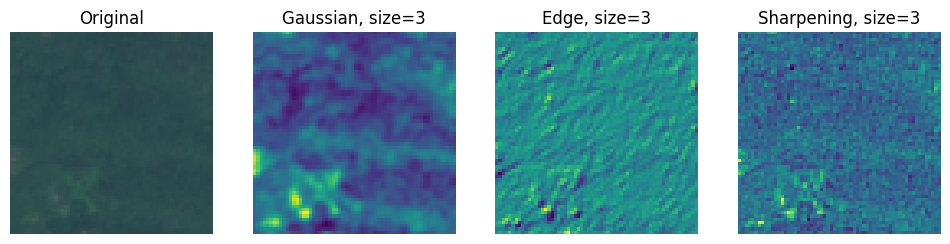

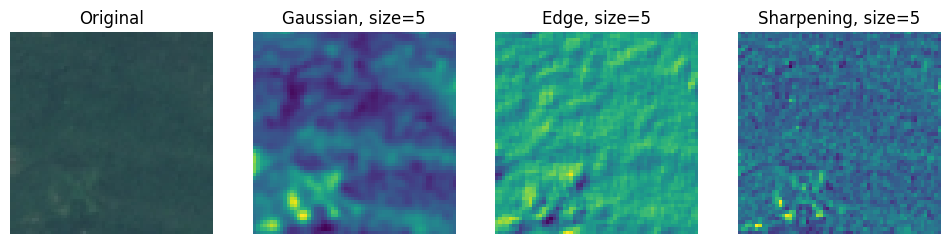

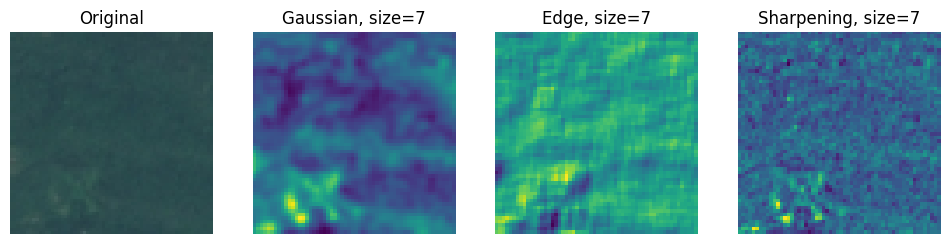

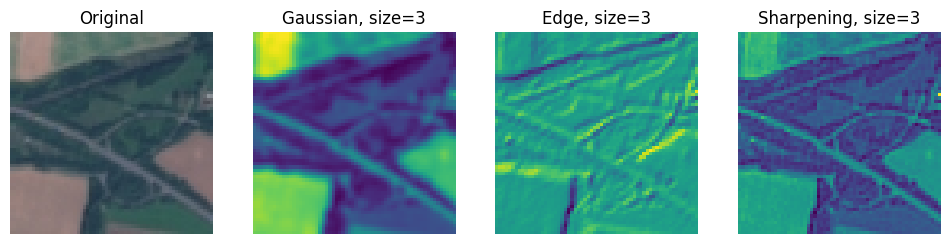

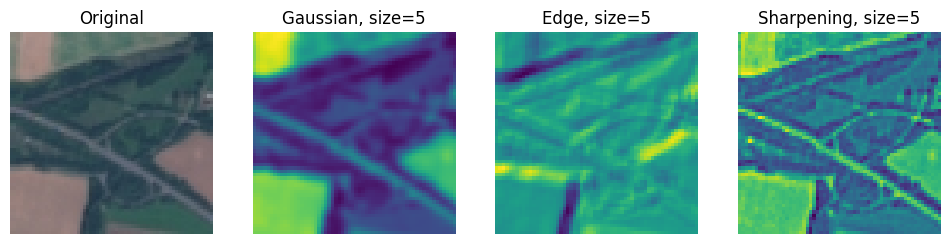

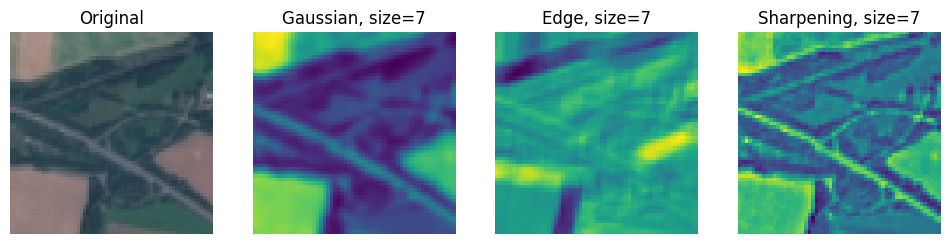

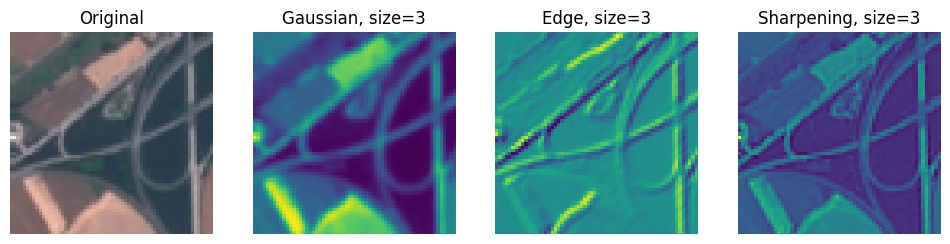

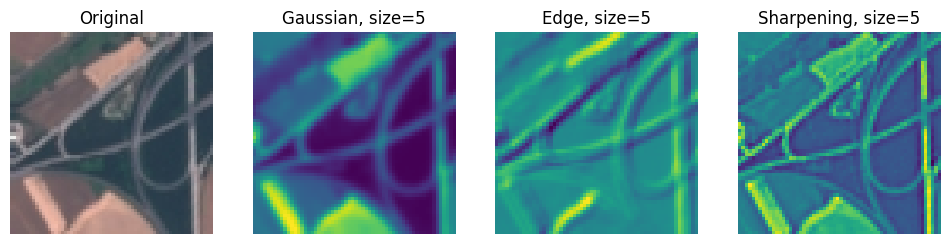

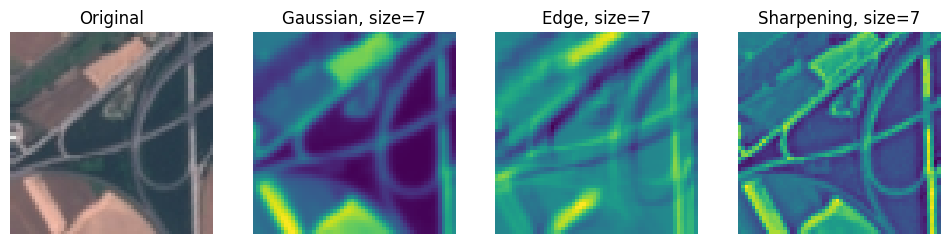

In [13]:
kernel_sizes = [3, 5, 7]

test_images = images[:3]

for image_idx in range(test_images.shape[0]):
   image = test_images[image_idx]
   
   for size in kernel_sizes:
       # Generate the kernels
       gaussian_kernel = gaussian_kernel_generator(size, sigma=1)
       edge_kernel = edge_detection_kernel_generator(size)
       sharpening_kernel = sharpening_kernel_generator(size, factor=1.5)
       
       # Apply the kernels
       gaussian_image = slice_over_input(image, 1, gaussian_kernel, 0)
       edge_image = slice_over_input(image, 1 , edge_kernel, 0)
       sharpening_image = slice_over_input(image, 1, sharpening_kernel, 0)
       
       # Plot the results
       fig, axes = plt.subplots(1, 4, figsize=(12, 3))
       axes[0].imshow(np.transpose(image,(1,2,0)))
       axes[0].set_title("Original")
       axes[0].axis("off")
       axes[1].imshow(np.transpose(gaussian_image, (1,2,0)))
       axes[1].set_title(f"Gaussian, size={size}")
       axes[1].axis('off')
       axes[2].imshow(np.transpose(edge_image, (1,2,0)))
       axes[2].set_title(f"Edge, size={size}")
       axes[2].axis('off')
       axes[3].imshow(np.transpose(sharpening_image, (1,2,0)))
       axes[3].set_title(f"Sharpening, size={size}")
       axes[3].axis('off')
       plt.show()


In [14]:
#define a CNN with residual connections
class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=1)

        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, padding=0, stride=1)
        else:
            self.conv3 = None
        
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.residual = Residual(32, use_1x1conv=True)
        self.convolutions = nn.Sequential(
            nn.LazyConv2d(16, kernel_size=5, stride = 2, padding=2), #output size 32x32
            nn.Tanh(),
            nn.LazyBatchNorm2d(),
            nn.MaxPool2d(kernel_size=2, stride=2), #output size 16x16
            self.residual,
            nn.MaxPool2d(kernel_size=2, stride=2), #output size 8x8
            nn.LazyConv2d(64, kernel_size=3),
            nn.Tanh(),
            nn.LazyBatchNorm2d(),
            nn.LazyConv2d(128, kernel_size=6),
            nn.Tanh()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.convolutions(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.classifier(x)
        return logits

In [15]:
#setting up mlflow
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('CNNClassifier')
mlflow.set_tracking_uri("file:///./runs/mlruns")

write "mlflow ui --backend-store-uri file:///./runs/mlruns" into terminal

In [16]:
#training of CNNClassifier
cl_model = CNNClassifier(num_classes=len(label_dict))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cl_model.parameters(), lr=config['learning_rate'])

mlflow.log_param('learning_rate', config['learning_rate'])
mlflow.log_param('batch_size', config['batch_size'])
mlflow.log_param('num_epochs', config['num_epochs'])
mlflow.log_param('image_size', config['image_size'])  

#epoch loop
for epoch in range(config['num_epochs']):
    running_loss = 0.0
    running_accuracy = []
    validation_accuracy = []

    #training
    cl_model.train()
    for i, (images, labels) in enumerate(train_dataloader):

        outputs = cl_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        running_accuracy.append(accuracy_score(labels.numpy(), predictions.numpy()))
    
    #validation
    cl_model.eval()  
    with torch.no_grad():  
        for images, labels in val_dataloader:
            outputs = cl_model(images)
            predictions = torch.argmax(outputs, dim=1)
            validation_accuracy.append(accuracy_score(labels.numpy(), predictions.numpy()))  

    #logging
    mlflow.log_metric('train_loss', running_loss, step=epoch)
    mlflow.log_metric("train_acc", np.mean(running_accuracy), step=epoch)
    mlflow.log_metric('val_acc', np.mean(validation_accuracy), step = epoch)
    #print(f'Epoch: {epoch+1}, Loss: {running_loss:.4f}, Training Accuracy: {np.mean(running_accuracy):.4f}, Validation Accuracy: {np.mean(validation_accuracy):.4f}')



In [25]:
#get pretrained models from huggingface
resnet_path = "../models/resnet50"
efficientnet_path = "../models/efficientnet"

if not os.path.exists(resnet_path):
    model_name = "microsoft/resnet-50"
    resnet = AutoModelForImageClassification.from_pretrained(
        model_name,
        num_labels=10,
        ignore_mismatched_sizes=True
    )
    feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

    resnet.save_pretrained(resnet_path)
else:
    resnet = AutoModelForImageClassification.from_pretrained(resnet_path, num_labels=10)

print("resnet loaded!")

if not os.path.exists(efficientnet_path):
    model_name = 'google/efficientnet-b0'
    efficientnet = AutoModelForImageClassification.from_pretrained(
        model_name,
        num_labels=10,
        ignore_mismatched_sizes=True
    )
    efficientnet.save_pretrained(efficientnet_path)
else:
    efficientnet = AutoModelForImageClassification.from_pretrained(efficientnet_path, num_labels=10)

print('efficientnet loaded!')

c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\modeling_utils.py:446: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(

resnet loaded!
efficientnet loaded!


In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Resnet-50 has {count_parameters(resnet):,} parameters')
print(f'Efficientnet-b0 has {count_parameters(efficientnet):,} parameters')


Resnet-50 has 23,528,522 parameters
Efficientnet-b0 has 4,020,358 parameters
